# Coding Exercise on Diffusion Model

## Overview

Introduction to the simplest diffusion model.

## Scenario
Image generation with Denoising Diffusion Probabilistic Model (DDPM).

## Method
We will be implementing [Denoising Diffusion Probablistic Model (DDPM)](https://arxiv.org/abs/2006.11239).

Research: read through several other papers, such as [Stable Diffusion](https://arxiv.org/abs/2112.10752).

In [1]:
!pip install einops
import numpy as np

import torch
from torch import nn, einsum
import torch.nn.functional as F

import torchvision.transforms as tfs

import math
from inspect import isfunction
from functools import partial

from einops import rearrange, reduce
from einops.layers.torch import Rearrange

from tqdm import tqdm

import urllib
import PIL

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## 1. Defining the U-Net model for diffusion.

The illustration below is from the stable diffusion paper, which depicts the architecture. Now our implementation of DDPM here does not contain the "conditioning" as in stable diffusion. 

(Conditioning: These are inputs to the model during inference stage that forces the model to generate the output conditioned on them. For example, in Dalle (native image generation support in GPT-4 chatbot), you can send it a text prompt and ask it to generate an image based on the text description you provide.)

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f6/Stable_Diffusion_architecture.png" width="600"/>
</div>


In [4]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )


def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) / (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# Define a neural network for the reverse diffusion process
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0) # changed to 1 and 0 from 7,3

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

## 2. Implementing the diffusion process.

### Forward process

In forward diffusion, given a data point sampled from a data distribution $x_0 \sim q(x)$, we want to get a noisy image at step $T$.

In particular, the forward diffusion is controlled by a variance schedule $\{ \beta_t \in (0, 1) \}_{t=1}^{T}$.

$$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t}  \textrm{ } x_{t-1}, \beta_t \textrm{ } \mathbf{I})$$
$$q(x_{1:T} | x_0) = \prod_{t=1}^T q(x_t | x_{t-1})$$

The sampled image $x_0$ gradually becomes noisier as the step $t$ becomes larger.

Eventually when $T \rightarrow \infty$, $x_T$ becomes to Gaussian noise. This is a Markov process and we can apply the formulation $T$ times to get to a noisy image at timestep $T$. If we do this in a Markovian manner, the process is slow and expensive.

Luckily, we can sample $x_t$ at any step $t$ **directly** using the reparameterization trick.

Let $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$

Then

$$q(x_t|x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) \mathbf{I})$$


### Reverse process (sampling)

Algorithm 2 in the paper.

$x_T \sim \mathcal{N}(0, \mathbf{I})$

**for** $t = T, ..., 1$ **do**

$\hspace{16pt} z \sim \mathcal{N}(0, \mathbf{I})$ if $t > 1$, else $z = 0$

$\hspace{16pt} x_{t-1} = \mu_{\theta}(x_t, t) + \sigma_t z = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_{\theta} (x_t, t) \right) + \sigma_t z$

**end for**

**return** x_0

In [5]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


class Diffusion(object):
    '''
    All-in-one place for diffusion.
    '''
    def __init__(self, timesteps: int = 300):
        self.timesteps = timesteps
        self.betas = self.linear_beta_schedule()
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def linear_beta_schedule(self):
        beta_start = 0.0001
        beta_end = 0.02
        return torch.linspace(beta_start, beta_end, self.timesteps)

    def q_sample(self, x_start, t, noise=None):
        '''
        Forward process
        '''
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

        sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(
            sqrt_one_minus_alphas_cumprod, t, x_start.shape
        )

        # \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \mathbf{I}
        q = sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
        return q

    @torch.no_grad()
    def p_sample(self, model, x, t, t_index):
        '''
        Reverse process
        '''
        betas_t = extract(self.betas, t, x.shape)

        sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        sqrt_one_minus_alphas_cumprod_t = extract(
            sqrt_one_minus_alphas_cumprod, t, x.shape
        )

        sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

        # Use our model (noise predictor) to predict the mean
        # Equation 11 in the paper (\mu_{\theta}(x_t, t)).
        model_mean = sqrt_recip_alphas_t * (x - (betas_t / sqrt_one_minus_alphas_cumprod_t) * model(x, t))

        if t_index == 0:
            return model_mean
        else:
            alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
            posterior_variance = self.betas * (1. - alphas_cumprod_prev) / (1. - self.alphas_cumprod)
            posterior_variance_t = extract(posterior_variance, t, x.shape)
            noise = torch.randn_like(x)
            p = model_mean + torch.sqrt(posterior_variance_t) * noise
            return p

    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        device = next(model.parameters()).device

        b = shape[0]
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []

        for i in tqdm(reversed(range(0, self.timesteps)), desc='sampling loop time step', total=self.timesteps):
            img = self.p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
            imgs.append(img.cpu().numpy())
        return imgs

    @torch.no_grad()
    def sample(self, model, image_size, batch_size=16, channels=3):
        return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


## 4. Our simple dataset: 1 image of a cat.

In [6]:
transform = tfs.Compose( # PIL -> torch
    [
        tfs.Resize((64, 64)),
        tfs.ToTensor(),
        # by default our image is scaled from 0 to 1, but we need it to be from -1 to 1
        # use a Lambda transform to scale the image
        tfs.Lambda(lambda t: (t*2) - 1)
    ]
)

reverse_transform = tfs.Compose( # torch -> PIL
    [
        tfs.Lambda(lambda t: (t+1)/2),
        # torch tensors are (C x H x W) but PIL expects (H x W x C)
        tfs.Lambda(lambda t: t.permute(1, 2, 0)),
        tfs.Lambda(lambda t: t*255.),
        tfs.Lambda(lambda t: t.numpy().astype(np.uint8)),
        tfs.ToPILImage()
    ]
)

def get_cat_image():
    url = 'https://upload.wikimedia.org/wikipedia/commons/6/64/Ragdoll_from_Gatil_Ragbelas.jpg'
    filename = 'cat.jpg'
    urllib.request.urlretrieve(url, filename)
    raw_image = PIL.Image.open(filename)
    return raw_image

def get_noisy_image(diffusion, x_start, t):
    # add noise
    x_noisy = diffusion.q_sample(x_start, t=t)

    # turn back into PIL image
    noisy_image = reverse_transform(x_noisy.squeeze())

    return noisy_image

cat_torch_img = transform(get_cat_image())

In [7]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, image_orig=None, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    _, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image_orig] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [8]:
plot([get_noisy_image(Diffusion(), cat_torch_img, torch.tensor([t])) for t in [0, 9, 19, 49, 99, 199, 299]])

## 5. Training and inference.

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 Loss: 0.25619837641716003



sampling loop time step: 100%|██████████| 300/300 [00:04<00:00, 69.31it/s]


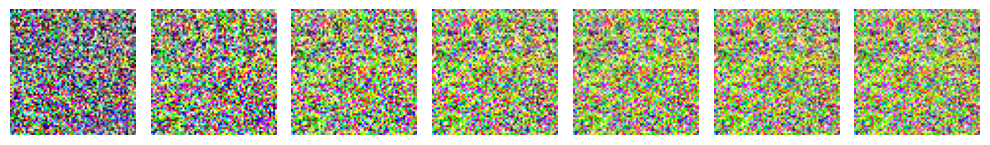

 20%|██        | 20/100 [00:17<00:48,  1.64it/s]

Epoch: 20 Loss: 0.019867438822984695



sampling loop time step: 100%|██████████| 300/300 [00:04<00:00, 69.97it/s]


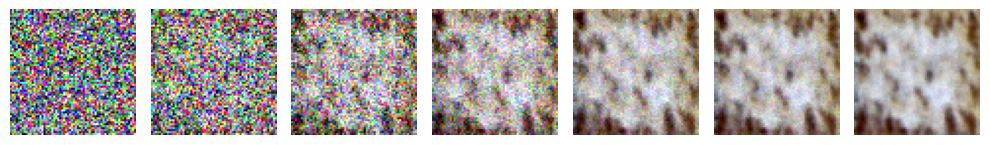

 40%|████      | 40/100 [00:33<00:36,  1.63it/s]

Epoch: 40 Loss: 0.011137736961245537



sampling loop time step: 100%|██████████| 300/300 [00:04<00:00, 69.96it/s]


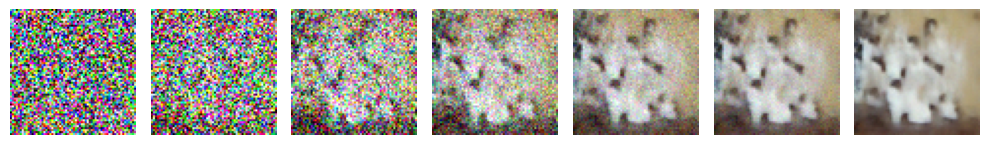

 60%|██████    | 60/100 [00:50<00:24,  1.63it/s]

Epoch: 60 Loss: 0.010845298878848553



sampling loop time step: 100%|██████████| 300/300 [00:04<00:00, 69.88it/s]


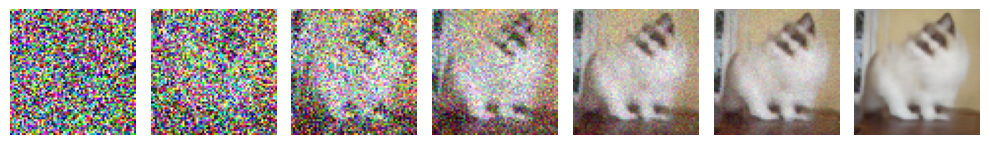

 80%|████████  | 80/100 [01:06<00:12,  1.63it/s]

Epoch: 80 Loss: 0.004533706232905388



sampling loop time step: 100%|██████████| 300/300 [00:04<00:00, 69.71it/s]


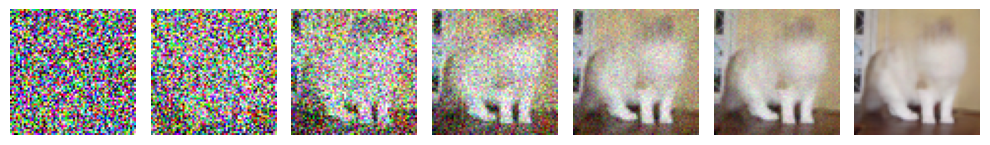

 99%|█████████▉| 99/100 [01:23<00:00,  1.63it/s]

Epoch: 99 Loss: 0.00452843401581049



sampling loop time step: 100%|██████████| 300/300 [00:04<00:00, 69.70it/s]


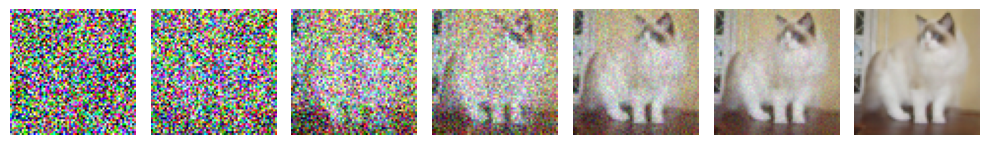

100%|██████████| 100/100 [01:28<00:00,  1.14it/s]


In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_channels = 3
batch_per_epoch = 10
batch_size = 16
image_size = 64
epochs = 100

dataloader = torch.utils.data.DataLoader([cat_torch_img] * batch_per_epoch * batch_size,
                                         batch_size=batch_size,
                                         num_workers=1,
                                         drop_last=True,
                                         shuffle=True)

diffusion = Diffusion()
model = Unet(
    dim=image_size,
    channels=num_channels,
    dim_mults=(1, 2, 4)
)
# model = UNet(img_channels=num_channels)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def p_losses(diffusion, denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = diffusion.q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

for epoch in tqdm(range(epochs)):
    for step, (batch) in enumerate(dataloader):
        optimizer.zero_grad()

        batch_size = batch.shape[0]
        batch = batch.to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device).long()

        loss = p_losses(diffusion, model, batch, t, loss_type="huber")

        loss.backward()
        optimizer.step()

    if epoch % 20 == 0 or epoch == epochs - 1:
        print("Epoch:", epoch, "Loss:", loss.item())
        # Show an image.
        with torch.no_grad():
            samples = diffusion.sample(model, image_size=image_size, batch_size=1, channels=num_channels)
            fig = plt.figure(figsize=(10, 2))
            for subplot_idx, time_idx in zip([0, 1, 2, 3, 4, 5, 6], [0, 99, 199, 249, 279, 289, 299]):
                ax = fig.add_subplot(1, 7, subplot_idx + 1)
                sampled_img = np.transpose(samples[time_idx][0], (1, 2, 0))
                ax.imshow(np.clip((sampled_img + 1)/2, 0, 1))
                ax.set_axis_off()
            fig.tight_layout()
            plt.show()